# Amazon Braket Hybrid Jobs と PennyLane による QAOA 

このチュートリアルでは、Amazon Braket Hybrid Jobs 内で PennyLane を使用し、Quantum Approximate Optimization Algorithm (QAOA) を用いて Max-Cut 問題を解きます。

## 内容
* Braket Jobs で事前準備された PennyLane コンテナを使用する
* QAOA のハイパーパラメータ を設定する
* PennyLane のバックエンドを選択する (TensorFlow, PyTorch, Base)
* Braket Jobs のチェックポイント機能を使用する

## QAOA について

QAOA は、パラメータ付き量子回路を用いて、二値最適化問題で与えられた古典的なコスト関数を評価する変分アルゴリズムです。回路のパラメータは、コスト関数を最小化するように調整されます。QAOA 自体も、回路の深さ ($p$) などのさまざまなパラメータを持ち、機械学習と同じように、これらのパラメータは一般に _ハイパーパラメータ_ と呼ばれます。以下では、問題の設定と、入力データの準備、そして Braket Jobs を使った　QAOA の実行について説明します。

QAOA と PennyLane についてさらに知りたい方は、[こちらの example notebook](https://github.com/aws/amazon-braket-examples/blob/main/examples/pennylane/2_Graph_optimization_with_QAOA/2_Graph_optimization_with_QAOA.ipynb) や [こちらの PennyLane チュートリアル](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html) もご確認ください。

## 問題の設定

Max-Cut 問題は、与えられたグラフを 2 つに分割する時に、その 2 つにまたがる辺の数を最大にするようなカットを探す問題です。理論物理や組合せ最適化の分野で応用されています。はじめに、<code>networkx</code> パッケージを用いて Max-Cut 問題用のランダムなグラフを作成し、可視化します。オプションとして、ノード数 <code>n</code> や辺の数 <code>m</code> は自由に調整して構いません。

In [1]:
import time

import networkx as nx
from braket.aws import AwsQuantumJob, AwsSession
from braket.jobs.image_uris import Framework, retrieve_image
import matplotlib.pyplot as plt

%matplotlib inline

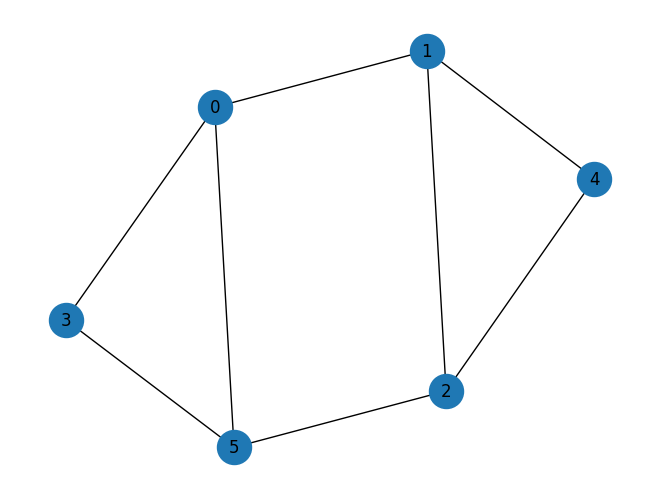

In [2]:
# ノード数 (num_nodes) と 辺の数 (num_edges) を定義し、その後 Max-Cut 問題用のランダムなグラフを作成します。
# ノード数 (num_nodes) は 1 量子ビットを表します。
# 注意: 回路の実行時間は num_nodes に対して指数関数的に増えます。
num_nodes = 6
num_edges = 8
seed = 1967

graph = nx.gnm_random_graph(num_nodes, num_edges, seed=seed)

# グラフの描画
positions = nx.spring_layout(graph, seed=seed)
nx.draw(graph, with_labels=True, pos=positions, node_size=600)

## 入力データの準備
次に、いわゆる隣接リストとして表される、解きたい最適化問題を Braket Job の入力データとして用意します。このベストプラクティスにより、問題の定義とアルゴリズムコードを切り離して考えることができます。形式は同じで、サイズの違う問題を考えたくなった際は、新しい入力データを用意するだけですみます。入力データはローカルファイルのパスか、S3 のパスとして指定します。今回の例では、ローカルディレクトリにある、問題グラフをエンコードしたファイルを作成します。

In [3]:
input_file_path = "input-data.adjlist"
nx.write_adjlist(graph, input_file_path)

## ハイパーパラメータの設定

ハイパーパラメータはジョブが作成された時に、引数 <code>hyperparameters</code> を通じて渡されます。ここには通常、実行中に調整したい全てのアルゴリズム設定が含まれます。例えば、使用する optimizer や学習率、イテレーション回数、デバイス実行ごとのショット数などです。

In [4]:
# interface には 'autograd', 'tf', 'torch' のいずれかを選びます。Autograd は PennyLane のベースコンテナです。
def define_hyperparameters(interface):
    hyperparameters = {
        # Number of tasks per iteration = 2 * (num_nodes + num_edges) * p + 1
        "p": 2,
        "seed": seed,
        # Maximum number of simultaneous tasks allowed
        "max_parallel": 10,
        # Number of total optimization iterations, including those from previous checkpoint (if any)
        "num_iterations": 5,
        # Step size / learning rate for gradient descent
        "stepsize": 0.1,
        # Shots for each circuit execution
        "shots": 1000,
        "interface": interface,
    }
    return hyperparameters

Braket Jobs には、TensorFlow, PyTorch, Base という、あらかじめ設定された 3 つのコンテナ環境が用意されています。

In [5]:
from braket.aws import AwsSession

region = AwsSession().region

# 使いたいコンテナを選びます。
def select_container(interface):
    if interface == "autograd":
        image_uri = retrieve_image(Framework.BASE, region)
    elif interface == "tf":
        image_uri = retrieve_image(Framework.PL_TENSORFLOW, region)
    elif interface == "torch":
        image_uri = retrieve_image(Framework.PL_PYTORCH, region)
    return image_uri

## アルゴリズムスクリプト

QAOA を用いて Max-Cut 問題を解く際に用いるアルゴリズムスクリプトは[こちら](qaoa/qaoa_algorithm_script.py)にあります。

## Base コンテナで Braket Job を実行する

これで、入力データ、アルゴリズムスクリプト、ハイパーパラメータ、各種設定を準備し終えました。いよいよ Braket Job を送信しましょう！

ジョブを作るために、以下の引数を指定します。
- <code>device</code>:　用いる Braket シミュレータか QPU の ARN です。アルゴリズムスクリプトの環境変数として保存されます。
- <code>source_module</code>: アルゴリズムスクリプトがあるファイルか python モジュールのパスです。Braket Job 実行時にコンテナにアップロードされます。
- <code>job_name</code>: ジョブを指定するユニークな文字列です。Braket Job のコンソールやジョブの ARN として確認できます。
- <code>image_uri</code>: Docker コンテナイメージのパスです。
- <code>entry point</code>: source_module からの相対パスです。Braket Job 開始時に実行されるコード部分です。
- <code>copy_checkpoints_from_job</code>: 現在のチェックポイントを持つジョブを指定する文字列です。`None` (デフォルト値) の場合、チェックポイントは現在のジョブにコピーされません。
- <code>hyperparameters</code>: ハイパーパラメータのキーと値を指定する Python 辞書です。
- <code>input_data</code>: チャンネル名を、ローカル環境のファイルの場所、または S3 へのパスのいずれかにマッピングする辞書です。ファイルの場所のみを指定することも可能で、その場合、チャンネル名は "input" として扱われます。
- <code>wait_until_complete</code>: True の場合、関数呼び出しは Braket Job が完了するまで待機し、さらにローカルコンソールにログを出力します。それ以外の場合は非同期で実行されます。デフォルト値は False です。

In [6]:
# Base コンテナを使うため、interface に autograd を指定します。
interface = "autograd"
hyperparameters = define_hyperparameters(interface)

# ジョブがターゲットとするデバイスを指定します。
device = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

# image_uri を設定します。
image_uri = select_container(interface)

In [7]:
job = AwsQuantumJob.create(
    device=device,
    source_module="qaoa",
    # ジョブ名はユニークな名前であれば何でも構いません。ただし 50 文字以内に収める必要があります。
    # (デフォルトの名前を使うにはコメントアウトしてください)
    job_name="qaoa-job-" + interface + "-" + str(int(time.time())),
    image_uri=image_uri,
    # source_module からの相対パス
    entry_point="qaoa.qaoa_algorithm_script",
    copy_checkpoints_from_job=None,
    # ハイパーパラメータ
    hyperparameters=hyperparameters,
    input_data={"input-graph": input_file_path},
    wait_until_complete=False,
)

## View results

ジョブが完了したら、結果と、アルゴリズムスクリプトで定義したメトリクスを表示できます。

In [8]:
%%time
# このセルの実行には 7-8 分かかります。
print(job.result())

{'params': [[0.19285119576374074, 0.3891312068052204], [-0.05425138802088254, -0.5188198990587166]], 'cost': -4.831, 'task summary': {'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 286000, 'tasks': {'COMPLETED': 286}, 'execution_duration': 5.282, 'billed_execution_duration': 858.0}}, 'estimated cost': 1.0725}
CPU times: user 233 ms, sys: 14.2 ms, total: 247 ms
Wall time: 4min 53s


In [9]:
# メトリクスが表示されるまでに少し待つ必要があるかもしれません。
# メトリクスがない場合、少し遅れて実行されます。
time.sleep(10)
print(job.metrics())

{'timestamp': [1684652481.9107428, 1684652398.6451497], 'braket_tasks_cost': [0.855, 0.21375], 'iteration_number': [3.0, 0.0], 'Cost': [-4.054, -3.895]}


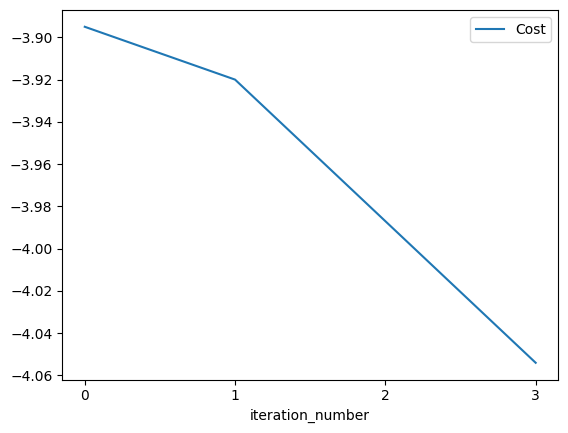

In [10]:
# メトリクスのプロット
import pandas as pd
from matplotlib.ticker import MaxNLocator

metrics_data = job.metrics()

if metrics_data: 
    df = pd.DataFrame(job.metrics())

    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    figure = df.plot(x="iteration_number", y="Cost", ax=ax)
else:
    print("Wait for metrics to populate and re-run the cell.")

In [11]:
print("Task Summary")
print(job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run tasks in this job: {job.result()['estimated cost']} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 286000, 'tasks': {'COMPLETED': 286}, 'execution_duration': 5.282, 'billed_execution_duration': 858.0}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 1.0725 USD


## Tensorflow コンテナで Braket Job を実行する

In [12]:
# Tensorflow コンテナを使うため、interface に tensorflow を指定します。
interface = "tf"
hyperparameters = define_hyperparameters(interface)

# ジョブがターゲットとするデバイスを指定します。
device = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

# image_uri を設定します。
image_uri = select_container(interface)

In [13]:
job = AwsQuantumJob.create(
    device=device,
    source_module="qaoa",
    # ジョブ名はユニークな名前であれば何でも構いません。ただし 50 文字以内に収める必要があります。
    # (デフォルトの名前を使うにはコメントアウトしてください)
    job_name="qaoa-job-" + interface + "-" + str(int(time.time())),
    image_uri=image_uri,
    # source_module からの相対パス
    entry_point="qaoa.qaoa_algorithm_script",
    copy_checkpoints_from_job=None,
    # ハイパーパラメータ
    hyperparameters=hyperparameters,
    input_data={"input-graph": input_file_path},
    wait_until_complete=False,
)

## View results

ジョブが完了したら、結果と、アルゴリズムスクリプトで定義したメトリクスを表示できます。

In [14]:
%%time
# このセルの実行には 8-9 分かかります。
print(job.result())

{'params': [[0.13745119770387193, 0.27693121084641537], [-0.09995138960636611, -0.4872199064020088]], 'cost': -4.9079999999999995, 'task summary': {'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 286000, 'tasks': {'COMPLETED': 286}, 'execution_duration': 5.211, 'billed_execution_duration': 858.0}}, 'estimated cost': 1.0725}
CPU times: user 421 ms, sys: 18.4 ms, total: 439 ms
Wall time: 9min 36s


In [15]:
# メトリクスが表示されるまでに少し待つ必要があるかもしれません。
# メトリクスがない場合、少し遅れて実行されます。
time.sleep(10)
print(job.metrics())

{'timestamp': [1684653041.1148043, 1684653017.746703, 1684652992.9937959, 1684652963.9690976, 1684652939.448934], 'braket_tasks_cost': [1.06875, 0.855, 0.64125, 0.4275, 0.21375], 'iteration_number': [4.0, 3.0, 2.0, 1.0, 0.0], 'Cost': [-4.229, -3.98, -3.979, -4.008, -4.041]}


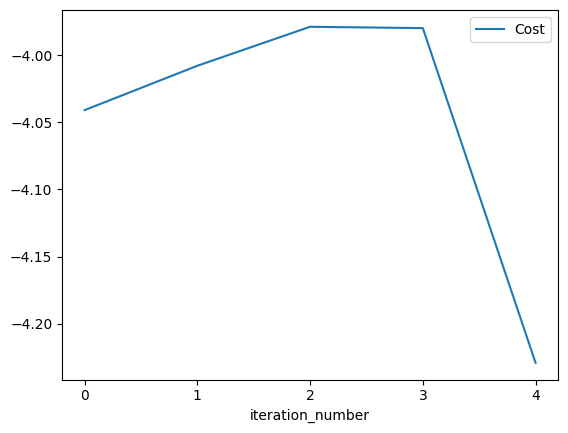

In [16]:
# メトリクスのプロット
import pandas as pd
from matplotlib.ticker import MaxNLocator

metrics_data = job.metrics()

if metrics_data: 
    df = pd.DataFrame(job.metrics())

    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    figure = df.plot(x="iteration_number", y="Cost", ax=ax)
else:
    print("Wait for metrics to populate and re-run the cell.")

In [17]:
print("Task Summary")
print(job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run tasks in this job: {job.result()['estimated cost']} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 286000, 'tasks': {'COMPLETED': 286}, 'execution_duration': 5.211, 'billed_execution_duration': 858.0}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 1.0725 USD


## チェックポイント
ジョブの進捗をチェックポイントとして定期的に保存しておくことがベストプラクティスです。例えば、ジョブが意図せず終了した場合や、QPU が使用できなくなった場合、新しいジョブを作成し、そのトレーニング進捗を *チェックポイント* からロードすることができます。チェックポイントを保存するには、アルゴリズムスクリプトに以下のようなコードを記述します。

In [18]:
%%script echo "Code in the algorithm script for saving a checkpoint"

for iteration in range(start_iteration, num_iterations):
    # 学習コードは省略 ...
    # ...
    save_job_checkpoint(
        checkpoint_data={
            "iteration": iteration + 1,
            "params": np_params.tolist(),
            "cost_before": cost_before,
        },
        checkpoint_file_suffix="checkpoint-1",
    )

Code in the algorithm script for saving a checkpoint


このコードは、チェックポイントファイル `<jobname>-checkpoint-1.json` を作成し、Job アーティファクトの checkpoints サブフォルダに上書きします。新しいジョブの開始時にチェックポイントからロードするには、アルゴリズムスクリプトに次のようなコードを記述します。

In [19]:
%%script echo "Code in the algorithm script for loading a checkpoint"

if "copy_checkpoints_from_job" in hyperparams:
    copy_checkpoints_from_job = hyperparams["copy_checkpoints_from_job"].split("/", 2)[-1]

if copy_checkpoints_from_job:
    checkpoint_1 = load_job_checkpoint(
        copy_checkpoints_from_job,
        checkpoint_file_suffix="checkpoint-1",
    )
    start_iteration = checkpoint_1["iteration"]
    params = interface.initialize_params(np.array(checkpoint_1["params"]))
    print("Checkpoint loaded")

Code in the algorithm script for loading a checkpoint


このコードは、チェックポイントファイルで指定されたタイミングとパラメータからアルゴリズムを開始します。

チェックポイントの読み込みを実際に見てみましょう。先ほどのジョブからチェックポイントを使用して新しいジョブを作成し、今回はさらに 2 回の追加イテレーションを行います。

In [20]:
new_hyperparameters = dict(hyperparameters)
# イテレーション数を 2 回増やす
new_hyperparameters["num_iterations"] = hyperparameters["num_iterations"] + 2
# さらに、新しいハイパーパラメータに以前のジョブ ARN を追加する
new_hyperparameters["copy_checkpoints_from_job"] = job.arn

start_time = time.time()

continued_job = AwsQuantumJob.create(
    device=device,
    source_module="qaoa",
    job_name="qaoa-job-continued-" + interface + "-" + str(int(time.time())),
    image_uri=image_uri,
    entry_point="qaoa.qaoa_algorithm_script",
    # チェックポイントをコピーするため、以前のジョブ ARN を指定する
    copy_checkpoints_from_job=job.arn,
    hyperparameters=new_hyperparameters,
    input_data={"input-graph": input_file_path},
    wait_until_complete=False,
)

end_time = time.time()

In [21]:
%time 
# このセルの実行には 8-9 分かかります。
continued_job.result()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


{'params': [[0.1966011985852756, 0.42108121299441775],
  [-0.1838513908565735, -0.6155199083138277]],
 'cost': -4.168,
 'task summary': {'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 115000,
   'tasks': {'COMPLETED': 115},
   'execution_duration': 2.828,
   'billed_execution_duration': 345.0}},
 'estimated cost': 0.43125}

In [26]:
# メトリクスが表示されるまでに少し待つ必要があるかもしれません。
# メトリクスがない場合、少し遅れて実行されます。
time.sleep(10)
print(continued_job.metrics())

{'timestamp': [1684653554.8270166, 1684653529.7489882], 'braket_tasks_cost': [0.4275, 0.21375], 'iteration_number': [6.0, 5.0], 'Cost': [-4.776, -4.875]}


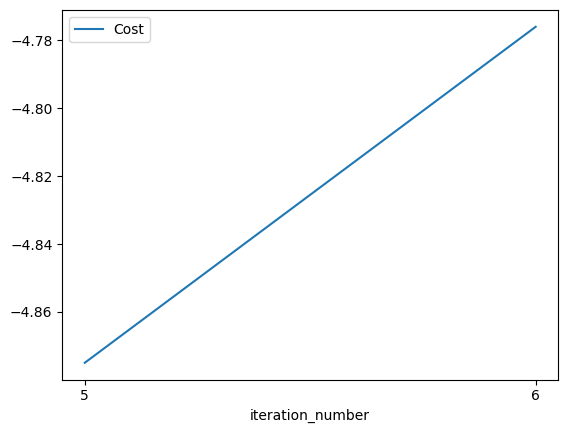

In [25]:
metrics_data = continued_job.metrics()

if metrics_data:
    df = pd.DataFrame(continued_job.metrics())

    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    figure = df.plot(x="iteration_number", y="Cost", ax=ax)
else: 
    print("Wait for metrics to populate and re-run the cell.")

In [24]:
print("Task Summary")
print(continued_job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run tasks in this job: {continued_job.result()['estimated cost']} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 115000, 'tasks': {'COMPLETED': 115}, 'execution_duration': 2.828, 'billed_execution_duration': 345.0}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 0.43125 USD


## まとめ

このチュートリアルでは、PennyLane を使用してランダムなグラフの Max-Cut 問題を作成しました。グラフをローカルファイルに保存し、Braket Job の入力データに与え、事前にビルドされた PennyLane コンテナイメージを実行しました。学習プロセスやオプティマイザに必要な変数は、ハイパーパラメータとして与えています。QAOA アルゴリズムが完了した後に結果が取得されます。最後に、チェックポイントを利用してジョブのトレーニング進捗を保存・読み込みする方法を紹介しました。